# 线性回归的从零开始实现
:label:`sec_linear_scratch`

在了解线性回归的关键思想之后，我们可以开始通过代码来动手实现线性回归了。
在这一节中，(**我们将从零开始实现整个方法，
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器**)。
虽然现代的深度学习框架几乎可以自动化地进行所有这些工作，但从零开始实现可以确保你真正知道自己在做什么。
同时，了解更细致的工作原理将方便我们自定义模型、自定义层或自定义损失函数。
在这一节中，我们将只使用张量和自动求导。
在之后的章节中，我们会充分利用深度学习框架的优势，介绍更简洁的实现方式。


In [1]:
%matplotlib inline 
# 默认嵌入到notebook里面。
import random
import torch
from d2l import torch as d2l

## 生成数据集

为了简单起见，我们将[**根据带有噪声的线性模型构造一个人造数据集。**]
我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。
我们将使用低维数据，这样可以很容易地将其可视化。
在下面的代码中，我们生成一个包含1000个样本的数据集，
每个样本包含从标准正态分布中采样的2个特征。
我们的合成数据集是一个矩阵$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$。

(**我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$
**)

你可以将$\epsilon$视为模型预测和标签时的潜在观测误差。
在这里我们认为标准假设成立，即$\epsilon$服从均值为0的正态分布。
为了简化问题，我们将标准差设为0.01。
下面的代码生成合成数据集。


In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b # 矩阵相乘, 构造y真实值. 
    y += torch.normal(0, 0.01, y.shape) # 加上偏置. 
    return X, y.reshape((-1, 1))

In [3]:
# 构建真实值
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000) # 生成真实的输入和输出

注意，[**`features`中的每一行都包含一个二维数据样本，
`labels`中的每一行都包含一维标签值（一个标量）**]。


In [4]:
print('features:', features[0],'\nlabel:', labels[0]) # 看一下第一个元素.,

features: tensor([0.9367, 0.8963]) 
label: tensor([3.0382])


通过生成第二个特征`features[:, 1]`和`labels`的散点图，
可以直观观察到两者之间的线性关系。


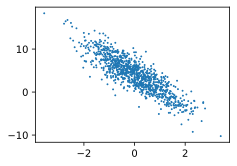

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

## 读取数据集

回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。
由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数，
该函数能打乱数据集中的样本并以小批量方式获取数据。

在下面的代码中，我们[**定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量**]。
每个小批量包含一组特征和标签。


In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features) # calculate length of 'features'
    indices = list(range(num_examples)) # index data sets
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices) # shuffle 打乱. 
    for i in range(0, num_examples, batch_size): # 每一次拿batchsize大小
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)]  # i是当前长度, batchsize是一组, num_examples是总长度.
            # 因为有out of index, 所以
        ) # 每次都计算拿出来的batchsize长度的, 随机的, index.
        yield features[batch_indices], labels[batch_indices] # 使用yield返回生成器. 这样我们不用每次计算, 而是用多少取多少. 

通常，我们利用GPU并行运算的优势，处理合理大小的“小批量”。
每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以被并行计算。
GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多。

我们直观感受一下小批量运算：读取第一个小批量数据样本并打印。
每个批量的特征维度显示批量大小和输入特征数。
同样的，批量的标签形状与`batch_size`相等。


In [7]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels): # 每次返回一组. iter
    print(X, '\n', y)
    # 返回的x就是[x1, x2], y就是输出值
    break

tensor([[ 1.6675, -2.5121],
        [-0.7027, -0.8042],
        [ 0.3576,  0.1543],
        [-0.5356,  0.0049],
        [ 0.0317,  0.8549],
        [-0.6421,  0.0234],
        [-0.0478,  0.8759],
        [ 1.1393, -0.8702],
        [-0.0961,  1.1032],
        [ 2.4999,  0.2651]]) 
 tensor([[16.0837],
        [ 5.5226],
        [ 4.3931],
        [ 3.1208],
        [ 1.3656],
        [ 2.8382],
        [ 1.1231],
        [ 9.4544],
        [ 0.2452],
        [ 8.2886]])


当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。
上面实现的迭代对于教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。
例如，它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。
在深度学习框架中实现的内置迭代器效率要高得多，
它可以处理存储在文件中的数据和数据流提供的数据。

## 初始化模型参数

[**在我们开始用小批量随机梯度下降优化我们的模型参数之前**]，
(**我们需要先有一些参数**)。
在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，
并将偏置初始化为0。


In [8]:
# 接下来我们定义模型. 
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True) # 使用normal正态分布初始化, 大小当然是和x的大小对应. 
b = torch.zeros(1, requires_grad=True)

在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。
每次更新都需要计算损失函数关于模型参数的梯度。
有了这个梯度，我们就可以向减小损失的方向更新每个参数。
因为手动计算梯度很枯燥而且容易出错，所以没有人会手动计算梯度。
我们使用 :numref:`sec_autograd`中引入的自动微分来计算梯度。

## 定义模型

接下来，我们必须[**定义模型，将模型的输入和参数同模型的输出关联起来。**]
回想一下，要计算线性模型的输出，
我们只需计算输入特征$\mathbf{X}$和模型权重$\mathbf{w}$的矩阵-向量乘法后加上偏置$b$。
注意，上面的$\mathbf{Xw}$是一个向量，而$b$是一个标量。
回想一下 :numref:`subsec_broadcasting`中描述的广播机制：
当我们用一个向量加一个标量时，标量会被加到向量的每个分量上。


In [9]:
def linreg(X, w, b):  #@save # 这里构造了一个计算式
    """线性回归模型"""
    return torch.matmul(X, w) + b # 返回y_pred, 也就是经过计算的值

## [**定义损失函数**]

因为需要计算损失函数的梯度，所以我们应该先定义损失函数。
这里我们使用 :numref:`sec_linear_regression`中描述的平方损失函数。
在实现中，我们需要将真实值`y`的形状转换为和预测值`y_hat`的形状相同。


In [10]:
def squared_loss(y_hat, y):  #@save # definite loss function.
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2 # 这里reshape保险一些. 然后按照元素做平方. 再/2 

## (**定义优化算法**)

正如我们在 :numref:`sec_linear_regression`中讨论的，线性回归有解析解。
尽管线性回归有解析解，但本书中的其他模型却没有。
这里我们介绍小批量随机梯度下降。

在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。
接下来，朝着减少损失的方向更新我们的参数。
下面的函数实现小批量随机梯度下降更新。
该函数接受模型参数集合、学习速率和批量大小作为输入。每
一步更新的大小由学习速率`lr`决定。
因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（`batch_size`）
来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。


In [11]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad(): # 我们更新参数的时候, 我们不需要保留梯度. 
        for param in params:
            param -= lr * param.grad / batch_size # 这就是更新公式. 
            # 更新后的参数 = 之前的参数 - learning rate * 该参数的梯度 (也就是沿着逆方向去更新该参数 -> called as 梯度下降)
            # 不过我们要计算的是平均梯度, 所以这里还要除以一个当前的batchsize. 
            param.grad.zero_() # empty gradient inplace  # 手动清零. 

## 训练

现在我们已经准备好了模型训练所有需要的要素，可以实现主要的[**训练过程**]部分了。
理解这段代码至关重要，因为从事深度学习后，
你会一遍又一遍地看到几乎相同的训练过程。
在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。
计算完损失后，我们开始反向传播，存储每个参数的梯度。
最后，我们调用优化算法`sgd`来更新模型参数。

概括一下，我们将执行以下循环：

* 初始化参数
* 重复以下训练，直到完成
    * 计算梯度$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * 更新参数$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

在每个*迭代周期*（epoch）中，我们使用`data_iter`函数遍历整个数据集，
并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。
这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设为3和0.03。
设置超参数很棘手，需要通过反复试验进行调整。
我们现在忽略这些细节，以后会在 :numref:`chap_optimization`中详细介绍。


In [12]:
# 制定一些超参数
lr = 0.03
num_epochs = 3 # 一轮, 也就是整个数据扫三遍. 每次样本都是随机的. 这样我们可以从总体样本中抽取不同的样本组合在一起, 这样使训练效果更好
net = linreg # 设置计算函数, (这里是获取函数句柄)
loss = squared_loss  # loss function. 同样是获取函数句柄. 

In [13]:
# there are two for loop 
for epoch in range(num_epochs): # 一轮. 
    for X, y in data_iter(batch_size, features, labels): # 每batch_size
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward() # 调用backward()进行反向传播, 计算梯度. 
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    # 一轮结束, 评价: 
    with torch.no_grad(): # 不需要梯度:
        train_l = loss(net(features, w, b), labels) # 看一下每轮的损失. 
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}') # 

epoch 1, loss 0.037657
epoch 2, loss 0.000144
epoch 3, loss 0.000051


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。
因此，我们可以通过[**比较真实参数和通过训练学到的参数来评估训练的成功程度**]。
事实上，真实参数和通过训练学到的参数确实非常接近。


In [14]:
# 看一下训练完后的真实值与估计值的差距. 
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0002, -0.0006], grad_fn=<SubBackward0>)
b的估计误差: tensor([7.2479e-05], grad_fn=<RsubBackward1>)


注意，我们不应该想当然地认为我们能够完美地求解参数。
在机器学习中，我们通常不太关心恢复真正的参数，而更关心如何高度准确预测参数。
幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解。
其中一个原因是，在深度网络中存在许多参数组合能够实现高度精确的预测。

## 小结

* 我们学习了深度网络是如何实现和优化的。在这一过程中只使用张量和自动微分，不需要定义层或复杂的优化器。
* 这一节只触及到了表面知识。在下面的部分中，我们将基于刚刚介绍的概念描述其他模型，并学习如何更简洁地实现其他模型。

## 练习

1. 如果我们将权重初始化为零，会发生什么。算法仍然有效吗？
1. 假设你是[乔治·西蒙·欧姆](https://en.wikipedia.org/wiki/Georg_Ohm)，试图为电压和电流的关系建立一个模型。你能使用自动微分来学习模型的参数吗?
1. 您能基于[普朗克定律](https://en.wikipedia.org/wiki/Planck%27s_law)使用光谱能量密度来确定物体的温度吗？
1. 如果你想计算二阶导数可能会遇到什么问题？你会如何解决这些问题？
1. 为什么在`squared_loss`函数中需要使用`reshape`函数？
1. 尝试使用不同的学习率，观察损失函数值下降的快慢。
1. 如果样本个数不能被批量大小整除，`data_iter`函数的行为会有什么变化？


[Discussions](https://discuss.d2l.ai/t/1778)
